## Regression Analysis on Best Model

In [1]:
"""
@author: Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
print(pd.__version__)
print(pd.__path__)
assert pd.__path__[0]!='/opt/anaconda/lib/python3.8/site-packages/pandas', 'Error! You are using deprecated python packages outside your conda environment. Did you use Jupyter Lab again?' 
# this is a nefarious problem with current version of anaconda, root cause is conda version install your own local one!
# lightly more superficial root cause is that you sometimes use jupyter lab which triggers you to use the /opt/anaconda/bin path backup when it sees jupyter lab isn't in local environment which breaks everything (uses outdated pandas)

2023-08-10 18:42:11.095860: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1.5.1
['/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/pandas']


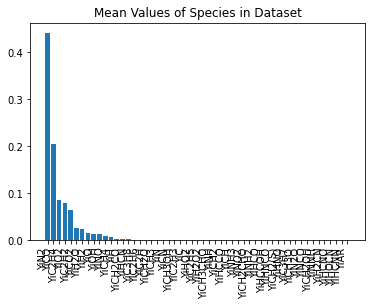

YiN2      0.440742
YiCO      0.205874
YiC2H4    0.086357
YiO2      0.079437
YiC2H2    0.065188
YiCO2     0.026813
YiH2O     0.025052
YiH2      0.015022
YiO       0.013979
YiOH      0.013009
dtype: float64

['YiN2', 'YiCO', 'YiC2H4', 'YiO2', 'YiC2H2', 'YiCO2', 'YiH2O', 'YiH2', 'YiO', 'YiOH']


In [2]:
BCs_only = False # turn on to only look at BCs!!

#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/TChem_collated.csv.gz') # TODO: change me!
df = dp.getDataframe()

########################################
### Look for biggest Species Values! ###
mean_vals = df.filter(like='Yi').mean()
sort_idx = np.argsort(mean_vals)
mean_vals = mean_vals[sort_idx][::-1]
plt.bar(mean_vals.index, mean_vals)
plt.title('Mean Values of Species in Dataset')
plt.xticks(rotation=90, ha="right")
plt.show()
display(mean_vals[:10])
important_species = list(mean_vals[:10].index)
print(important_species)
########################################

if BCs_only:
    #df = df.sample(2)
    df=pd.concat([df.iloc[:1], df.iloc[-1:]],axis=0) # select boundary conditions!
    df.index=range(len(df))
    dp.df = df

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)
dm.train_portion=0.9

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())
exprExec.use_dynamic_pred=True

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2023-08-10 18:42:20.694569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 18:42:21.069021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12277 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

In [ ]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
emb_and_regressor = bestModel = bestModel.get_layer('emb_and_regression_model')
print(experimentSettings.keys())
print(experimentSettings['dataSetMethod'])
#dm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])
dm = experimentSettings['data_manager']

print(f'\nexperimentSettings: {str(experimentSettings)[:300]}...')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')

In [ ]:
# simpler than reconstructing, but sanity is good...
linear_embedder = bestModel.get_layer('linear_embedding')
regressor = bestModel.get_layer('regressor')

print(bestModel.input_shape)
print(bestModel.output_shape)
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

## Manually Construct Data & Prepare Model:

In [ ]:
X_train, X_test, Y_train, Y_test, zmix_train, zmix_test = dm.getTrainTestData()
source_train, source_test = dm.getSourceTrainTestData()

if BCs_only: # This is a hack to plot regression analysis for just the boundary cases
    X_test, Y_test, zmix_test, source_test = dm.getAllData()

In [ ]:
CPV_train = linear_embedder({"species_input": np.asarray(X_train)})
true_dyn_train = linear_embedder({"species_input": np.asarray(source_train)})
true_dyn_test = linear_embedder({"species_input": np.asarray(source_test)})

In [ ]:
input_dict_train = {"species_input": X_train, 'zmix': zmix_train}
input_dict_test = {"species_input": X_test, 'zmix': zmix_test}
output_dict_train = {'static_source_prediction': Y_train, 'dynamic_source_prediction': true_dyn_train}
output_dict_test = {'static_source_prediction': Y_test, 'dynamic_source_prediction': true_dyn_test}

In [ ]:
from models import pcdnnv2_model_factory

@tf.function
def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt,axis=0))

# for metric definitions see get_metric_dict()
metrics={'static_source_prediction': R2, 'dynamic_source_prediction': R2}
emb_and_regressor.compile(loss=None, optimizer='adam', metrics=metrics)

# Best Model Evaluation:
## R^2 Eval -- 
(**NOTE: requires max batch size or you get erroneous results!**)

In [ ]:
# Verified to make "raw evaluation" (7/27/22) (as long as batch size is entire dataset!)
eval_func = lambda input_dict, output_dict: emb_and_regressor.evaluate(input_dict, output_dict, 
                                                                       batch_size=input_dict['species_input'].shape[0],
                                                                       return_dict=True, verbose=False)

eval_ = eval_func(input_dict_test, output_dict_test)
print(eval_)

print(f'Total loss: {eval_["loss"]}')
print(f'CPV_source_prediction R^2: {eval_["dynamic_source_prediction_R2"]}')
print(f'Static_deps_prediction R^2: {eval_["static_source_prediction_R2"]}')
print(f'Average R^2: {(eval_["dynamic_source_prediction_R2"]+eval_["static_source_prediction_R2"])/2}')

In [ ]:
experimentSettings.keys()
experimentSettings['val_losses']

## QQ regression plots:

In [ ]:
import matplotlib.pyplot as plt

# QQ plots are good!!
#all_dependants = ["souener", "souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
all_dependants = ["souener"] + dm.input_data_cols
print(dm.input_data_cols)
def make_Error_plots(input_dict, output_dict, name, plot_residuals=False, names=None):
    preds = emb_and_regressor.predict(input_dict)
    if names is None: names = list(range(preds[name].shape[1]))
    
    residuals = output_dict[name]-preds[name]
    print('mae', np.mean(np.abs(residuals)))
    Y_vals = residuals if plot_residuals else preds[name]
    plt_name = 'Residual' if plot_residuals else 'Q-Q'
    
    for i in range(preds[name].shape[1]):
        plt.figure(i)
        plt.plot(output_dict[name][:, i], Y_vals[:,i], '.')
        plt.title(f'{plt_name} Plot {name}-{names[i]}')
        plt.show()
    return residuals
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=False)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=False)

## Compare Boundary Conditions Predictions to Real Values

In [ ]:
if BCs_only:
    preds = emb_and_regressor.predict(input_dict_test)
    preds = pd.DataFrame(dm.outputScaler.inverse_transform(preds['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    targets = pd.DataFrame(dm.outputScaler.inverse_transform(output_dict_test['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    preds = preds[important_species]
    targets = targets[important_species]

    print('test inputs: ')
    display(input_dict_test)
    print('targets: ')
    display(targets)
    print('preds: ')
    display(preds)

    plt.bar(preds.columns, preds.iloc[0])
    plt.xticks(rotation=90, ha="right")
    plt.title('Predictions')
    plt.show()

    plt.bar(preds.columns, targets.iloc[0])
    plt.xticks(rotation=90, ha="right")
    plt.title('Targets')
    plt.show()

## Residual Regression Plots:

In [ ]:
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=True)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=True)

### CPV Distribution Plots (its Weird!):

In [ ]:
for i in range(CPV_train.shape[1]):
    plt.figure(i)
    plt.hist(CPV_train[:,i].numpy().squeeze())
    plt.title(f'CPV-{i} hist')
    plt.show()

In [ ]:
# Sanity check on names!
def sanity_check_names(): # function to prevent namespace pollution
    input_dict_train, input_dict_test, output_dict_train, output_dict_test = exprExec.prepare_model_data_dicts(dm=dm)
    X_train_cols = dm.df_testing[dm.input_data_cols].columns
    source_train_cols = source_train.columns

    # check that order of source-terms matches order of species
    assert all(np.array([col[2:] for col in X_train_cols]) == np.array([col[7:] for col in source_train_cols]))
sanity_check_names()